In [1]:
import numpy as np
import torch
import pyepo

# random seed
np.random.seed(42)
torch.manual_seed(42)

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from pyepo.model.grb import tspDFJModel, tspGGModel
# set solver
optmodel = tspDFJModel(num_node)
optmodel_gg = tspGGModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-09
Obj: 57.6036
0 -> 5 -> 8 -> 10 -> 4 -> 12 -> 1 -> 17 -> 3 -> 16 -> 9 -> 18 -> 7 -> 2 -> 11 -> 13 -> 19 -> 6 -> 14 -> 15 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)

In [5]:
from dataset import optDatasetConstrs
# get training and test data set
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train) # with binding constr
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test) # without binding constr

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 169.90it/s]


Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.15it/s]


In [6]:
# get training and test data set without costs
dataset_train = optDatasetConstrs(optmodel, x_train, sols=dataset_train_cost.sols) # with binding constr

Obtaining constraints for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 124.60it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt
def plot(loss_log, regret_log, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Learning Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    # draw plot
    fig = plt.figure(figsize=(16, 8))
    plt.plot(range(0, num_epochs+1, log_step), regret_log, color="royalblue", ls="--", alpha=0.7, lw=5, label="Regret")
    plt.xticks(range(0, num_epochs+1, 50), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.title("Learning Curve on Test Set", fontsize=36)
    plt.show()

## Train

In [10]:
import time
def train(reg, loss_func, lr, num_epochs, log_step):
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # init log
    loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
    # running time
    elapsed = 0
    for epoch in range(num_epochs):
        tick = time.time()
        for data in loader_train:
            x, w, t_ctr = data
            # forward pass
            cp = reg(x)
            loss = loss_func(cp, t_ctr)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
        # record time
        tock = time.time()
        elapsed += tock - tick
        if (epoch+1) % log_step == 1:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
            regret_log.append(regret_val)
            print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                  format(epoch, loss.item(), regret_trn*100, regret_val*100))
    print("Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, regret_log

### 2-Stage 

In [11]:
# init model
reg = LinearRegression()

In [12]:
from torch import nn
# init loss
mse = nn.MSELoss()

In [13]:
lr = 1e-2
num_epochs = 30
log_step = 2
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train_cost:
        x, c, _, _ = data
        # forward pass
        cp = reg(x)
        loss = mse(cp, c)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
              format(epoch, loss.item(), regret_trn*100, regret_val*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  63.2928, Train Regret:  68.3836%, Val Regret:  68.5267%
Epoch   2, Loss:  45.9140, Train Regret:  28.1556%, Val Regret:  28.4913%
Epoch   4, Loss:  34.7517, Train Regret:  23.7259%, Val Regret:  24.4872%
Epoch   6, Loss:  33.2044, Train Regret:  22.1929%, Val Regret:  22.8940%
Epoch   8, Loss:  20.1062, Train Regret:  21.5325%, Val Regret:  22.2450%
Epoch  10, Loss:  22.1723, Train Regret:  21.0071%, Val Regret:  21.6249%
Epoch  12, Loss:  26.6795, Train Regret:  20.8728%, Val Regret:  21.3654%
Epoch  14, Loss:  12.8518, Train Regret:  20.3588%, Val Regret:  20.8854%
Epoch  16, Loss:  12.2079, Train Regret:  19.9268%, Val Regret:  20.4393%
Epoch  18, Loss:  12.7147, Train Regret:  19.3991%, Val Regret:  19.8790%
Epoch  20, Loss:  16.8677, Train Regret:  18.9488%, Val Regret:  19.3843%
Epoch  22, Loss:   8.7846, Train Regret:  18.3594%, Val Regret:  18.8107%
Epoch  24, Loss:   5.2373, Train Regret:  17.7488%, Val Regret:  18.0877%
Epoch  26, Loss:   7.8300, Train Regre

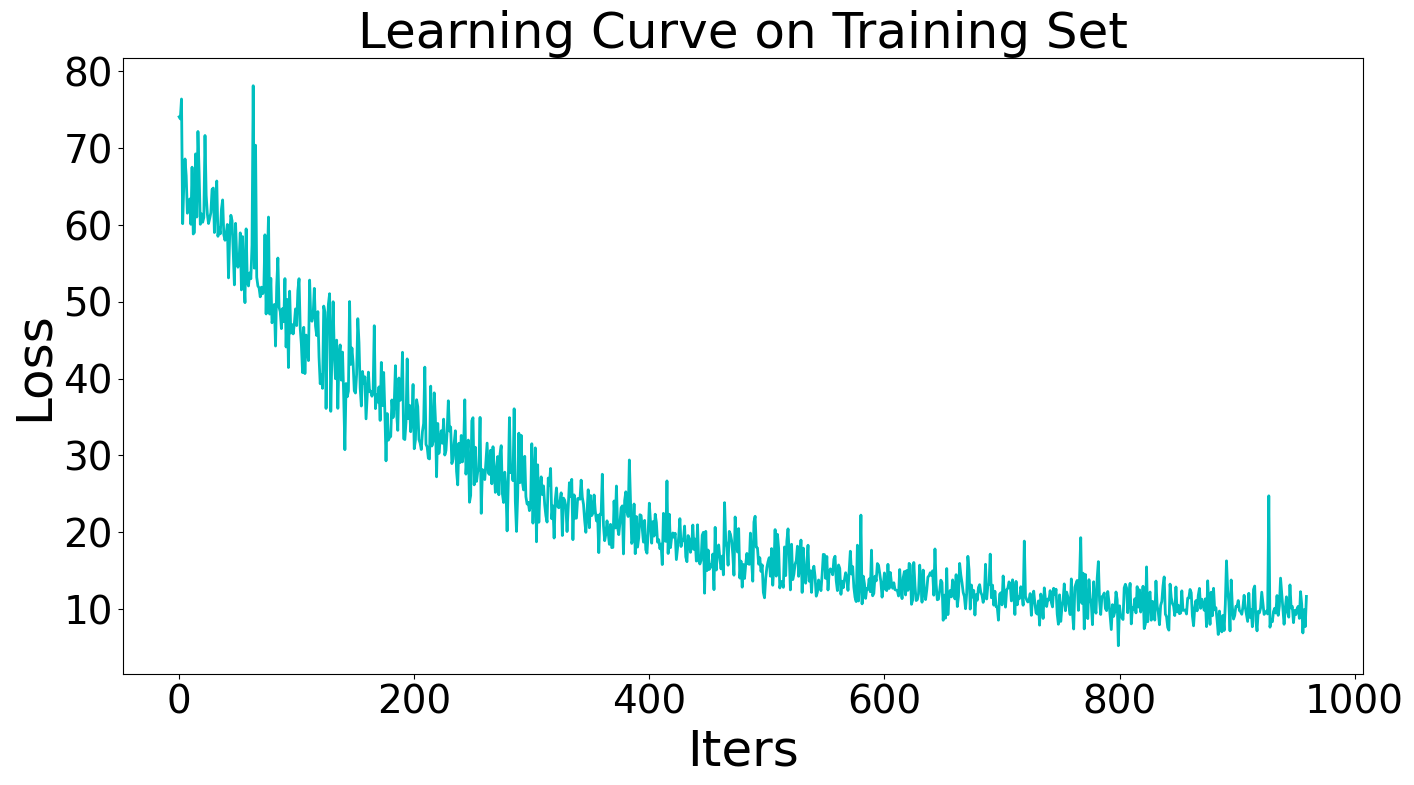

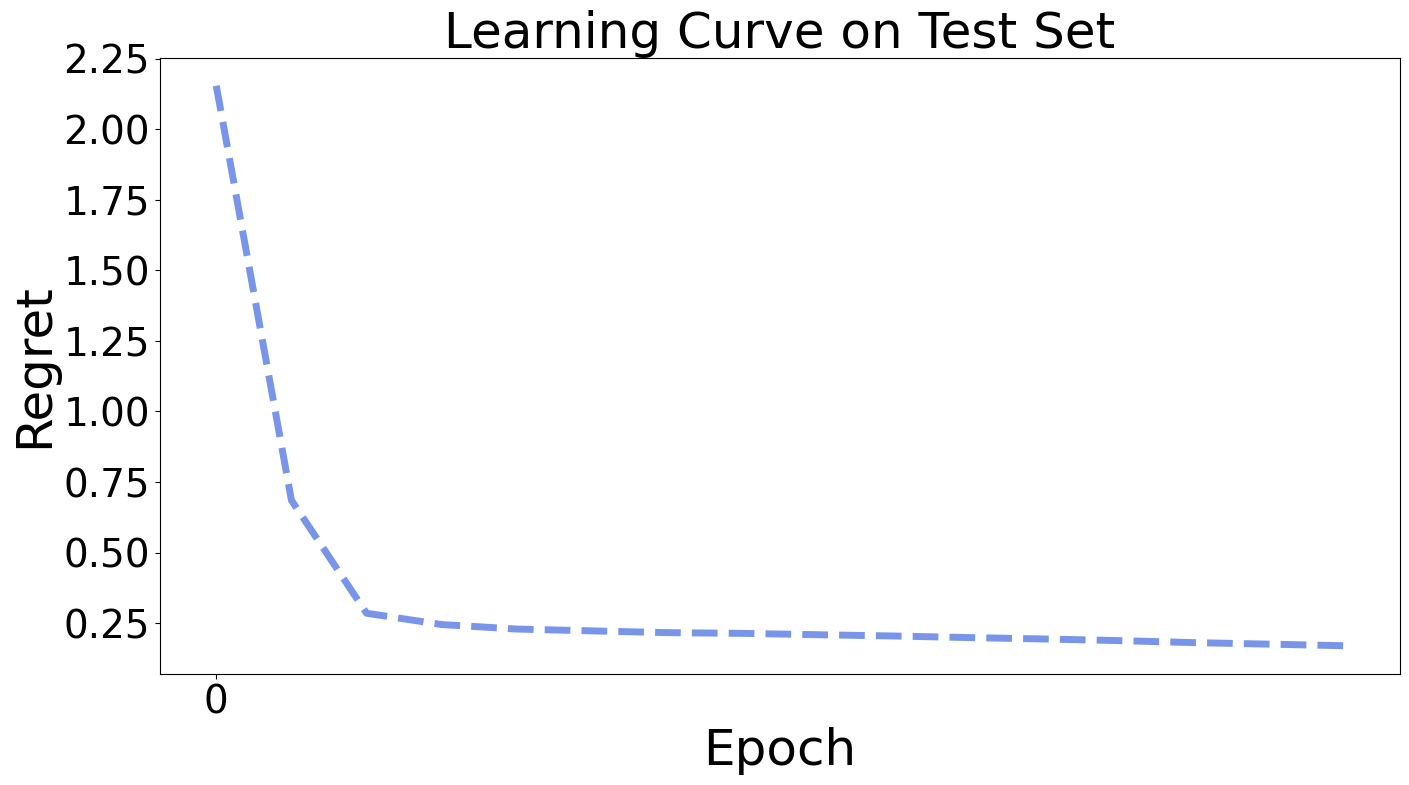

In [14]:
plot(loss_log, regret_log, num_epochs, log_step)

### Exact Method 

In [15]:
# init model
reg = LinearRegression()

In [16]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel_gg)

In [17]:
lr = 1e-2
num_epochs = 30
log_step = 2
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.9845, Train Regret:  66.1837%, Val Regret:  66.3797%
Epoch   2, Loss:  -0.9981, Train Regret:  17.1924%, Val Regret:  18.2481%
Epoch   4, Loss:  -0.9988, Train Regret:  10.8374%, Val Regret:  12.0839%
Epoch   6, Loss:  -0.9988, Train Regret:   8.8848%, Val Regret:   9.9855%
Epoch   8, Loss:  -0.9996, Train Regret:   8.1529%, Val Regret:   8.9276%
Epoch  10, Loss:  -0.9997, Train Regret:   7.6849%, Val Regret:   8.5617%
Epoch  12, Loss:  -0.9995, Train Regret:   7.4294%, Val Regret:   8.3437%
Epoch  14, Loss:  -0.9997, Train Regret:   7.3866%, Val Regret:   8.3125%
Epoch  16, Loss:  -0.9998, Train Regret:   7.3385%, Val Regret:   8.1056%
Epoch  18, Loss:  -0.9997, Train Regret:   7.3108%, Val Regret:   8.0953%
Epoch  20, Loss:  -0.9998, Train Regret:   7.2985%, Val Regret:   8.0677%
Epoch  22, Loss:  -0.9997, Train Regret:   7.4341%, Val Regret:   7.9480%
Epoch  24, Loss:  -0.9998, Train Regret:   7.4512%, Val Regret:   8.1274%
Epoch  26, Loss:  -0.9998, Train Regre

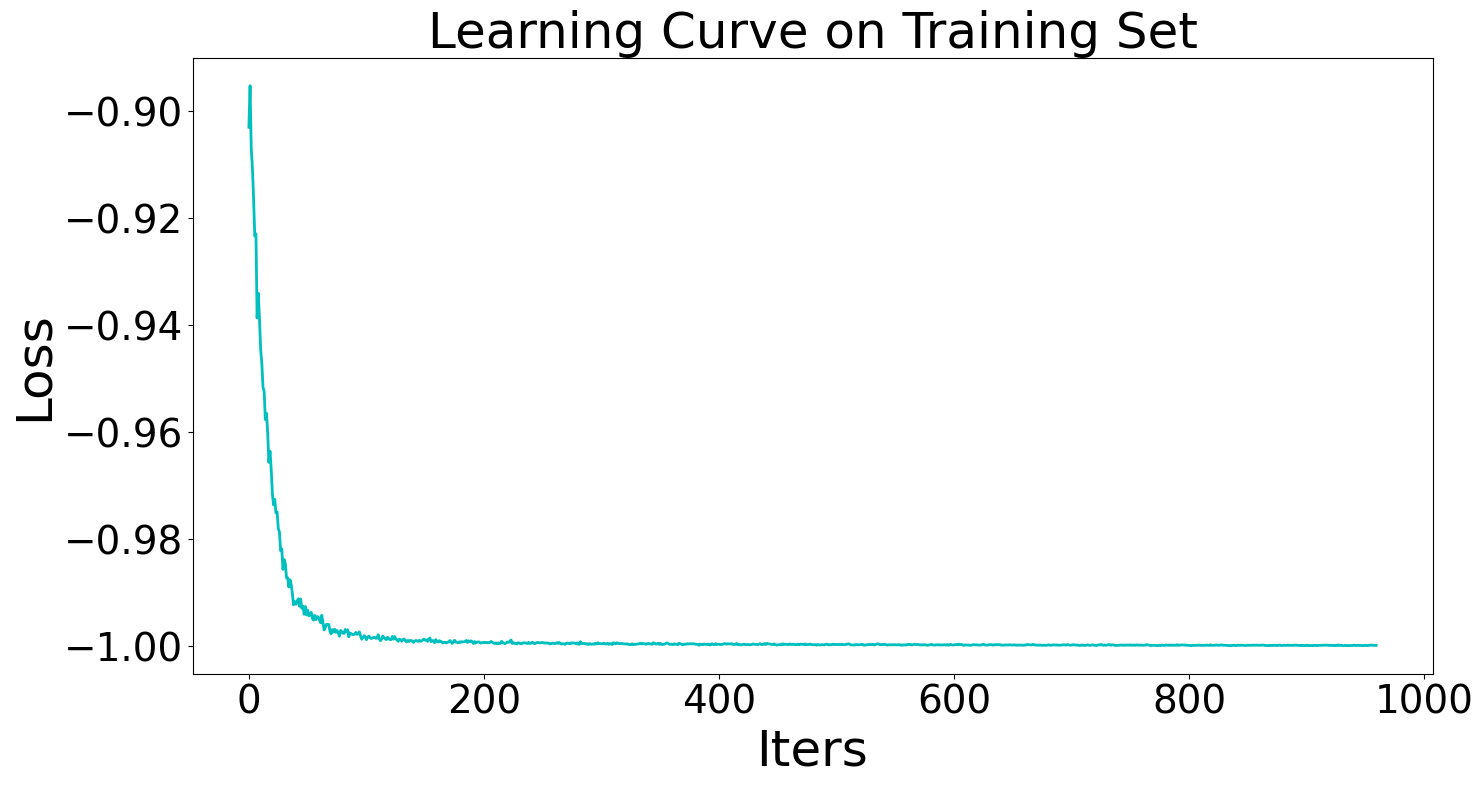

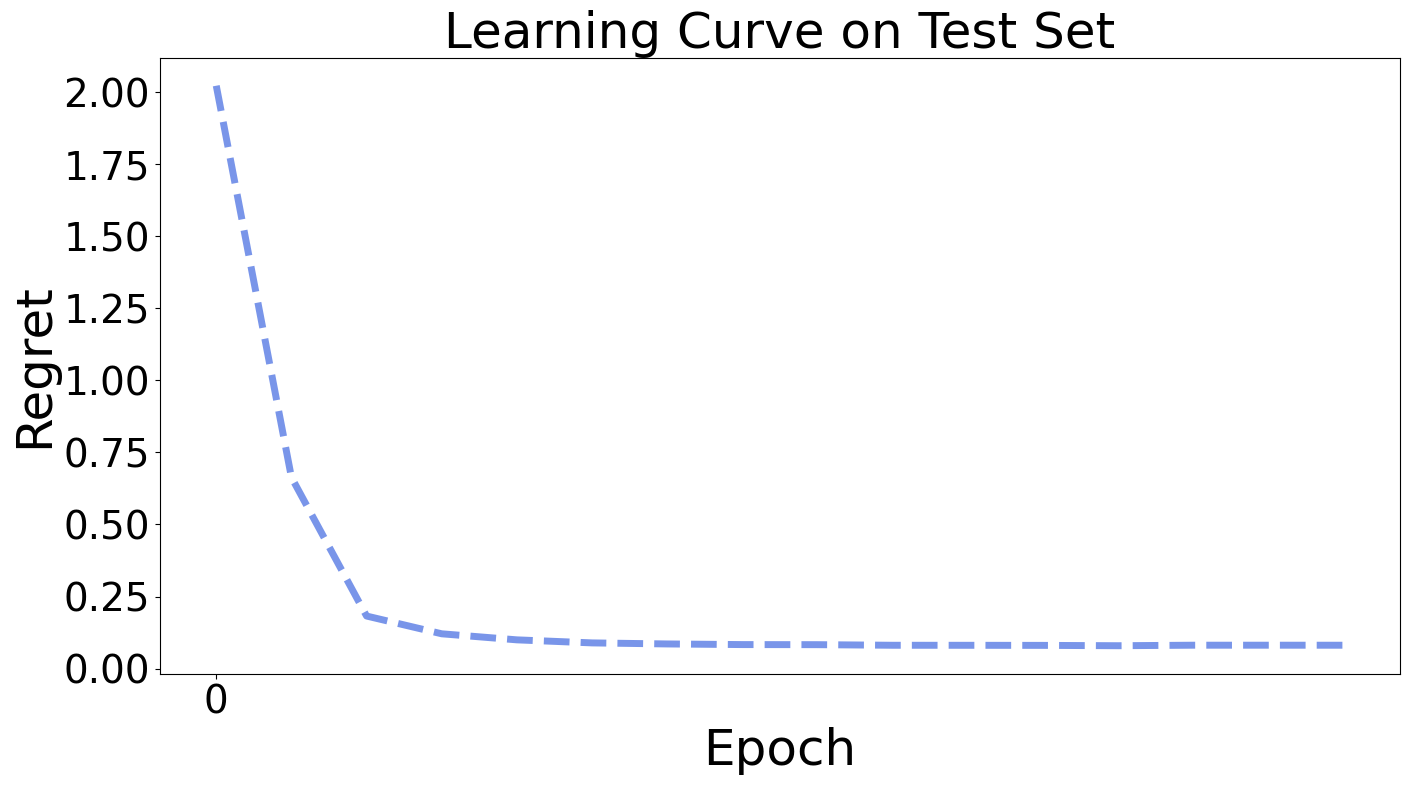

In [18]:
plot(loss_log, regret_log, num_epochs, log_step)

### Sampling Method

In [19]:
# init model
reg = LinearRegression()

In [20]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel_gg, n_samples=100)

In [21]:
lr = 1e-2
num_epochs = 30
log_step = 2
loss_log, regret_log = train(reg, ca_cos, lr, num_epochs, log_step)

Epoch   0, Loss:  -0.5572, Train Regret:  81.7079%, Val Regret:  84.2277%
Epoch   2, Loss:  -0.8235, Train Regret:  15.5131%, Val Regret:  16.2858%
Epoch   4, Loss:  -0.8155, Train Regret:  14.3887%, Val Regret:  14.8832%
Epoch   6, Loss:  -0.8214, Train Regret:  14.4546%, Val Regret:  14.2268%
Epoch   8, Loss:  -0.8052, Train Regret:  14.6846%, Val Regret:  14.6791%
Epoch  10, Loss:  -0.8173, Train Regret:  14.1955%, Val Regret:  14.7279%
Epoch  12, Loss:  -0.8290, Train Regret:  14.0251%, Val Regret:  14.5809%
Epoch  14, Loss:  -0.7954, Train Regret:  14.0702%, Val Regret:  14.5208%
Epoch  16, Loss:  -0.8268, Train Regret:  13.8621%, Val Regret:  14.5580%
Epoch  18, Loss:  -0.8176, Train Regret:  14.3201%, Val Regret:  15.0236%
Epoch  20, Loss:  -0.8169, Train Regret:  14.3260%, Val Regret:  14.7995%
Epoch  22, Loss:  -0.8108, Train Regret:  14.0146%, Val Regret:  14.4317%
Epoch  24, Loss:  -0.8146, Train Regret:  14.3456%, Val Regret:  14.4593%
Epoch  26, Loss:  -0.8148, Train Regre

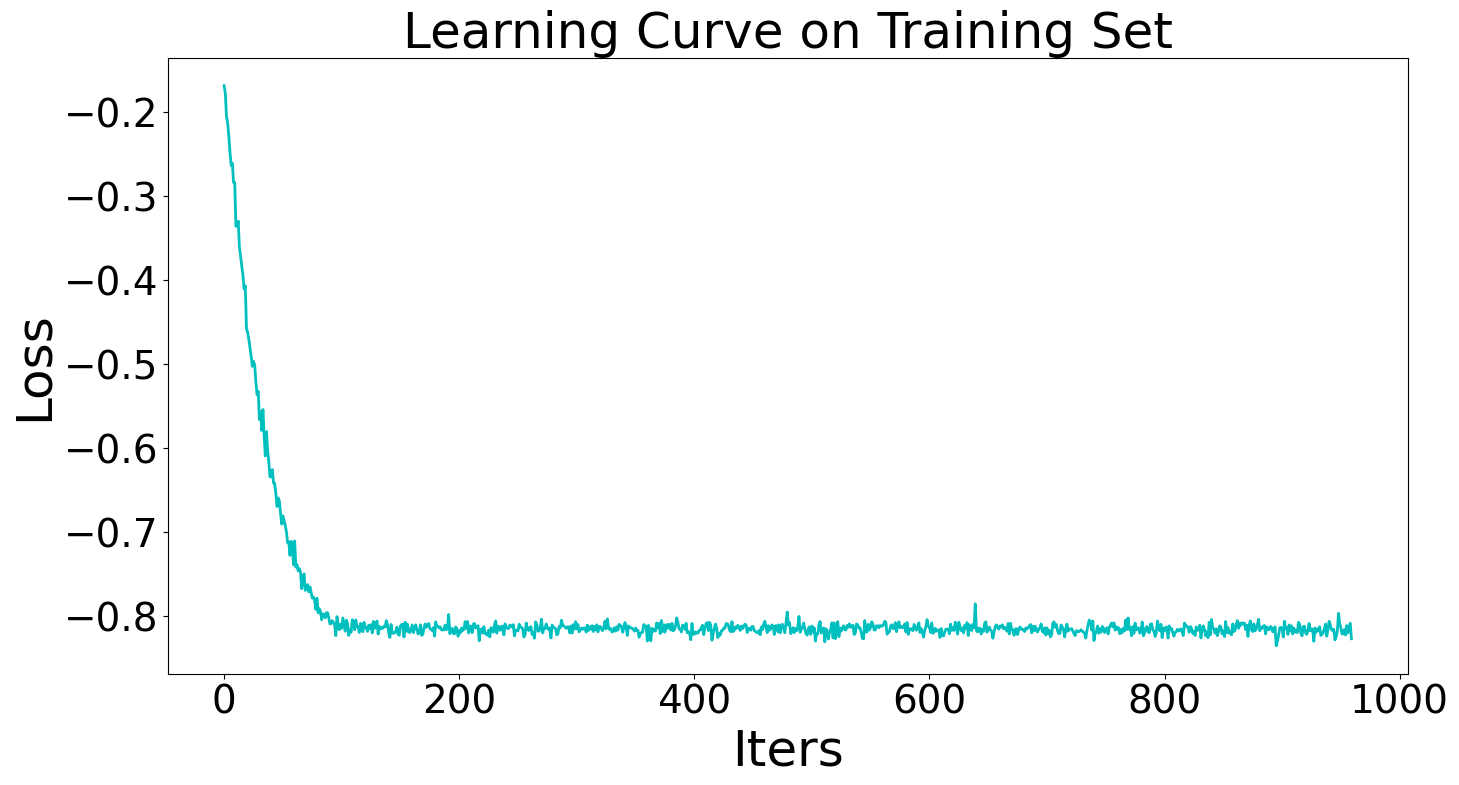

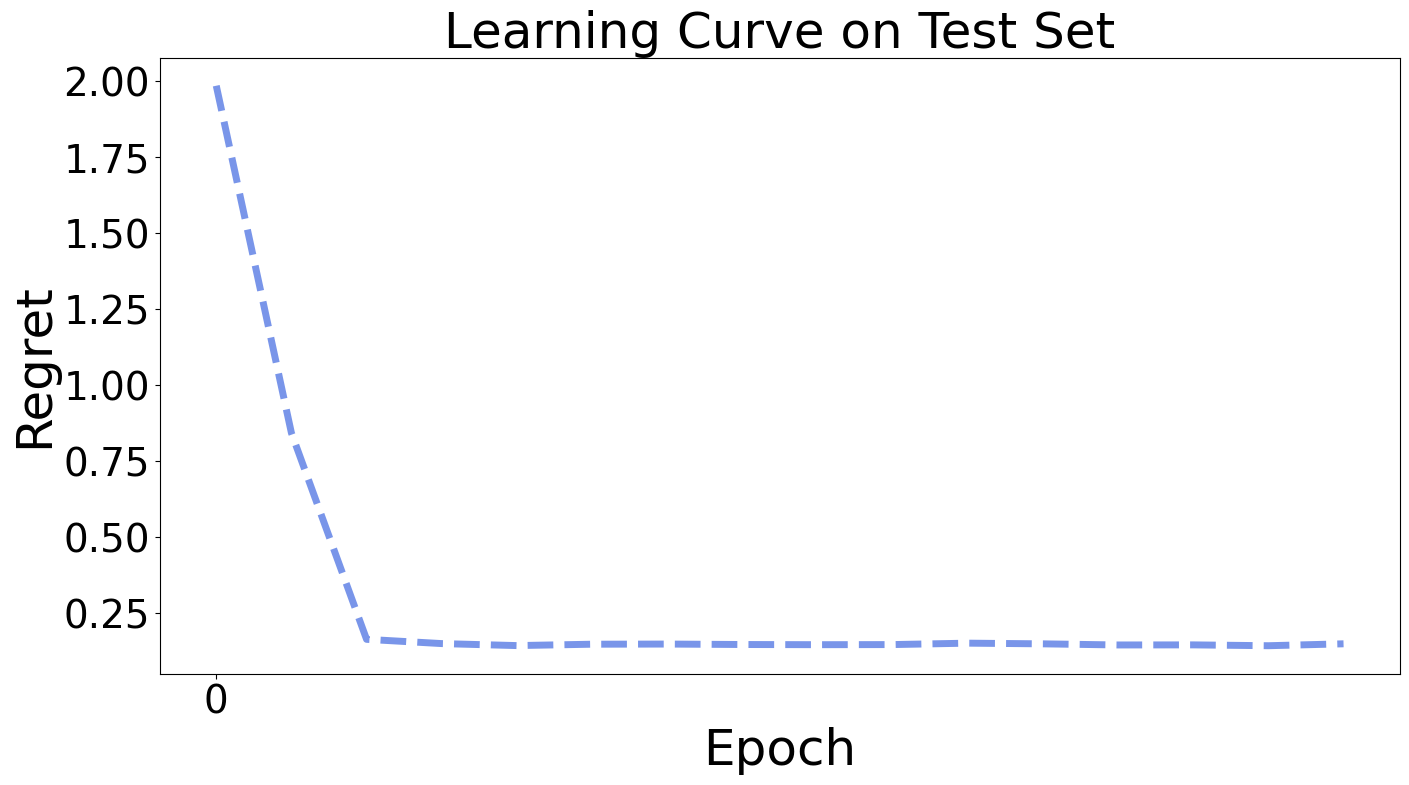

In [22]:
plot(loss_log, regret_log, num_epochs, log_step)

### PFYL 

In [23]:
# init model
reg = LinearRegression()

In [24]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0)

Num of cores: 1


In [25]:
lr = 1e-2
num_epochs = 30
log_step = 2
# set optimizer
optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
# init log
loss_log, regret_log = [], [pyepo.metric.regret(reg, optmodel, loader_test)]
# running time
elapsed = 0
for epoch in range(num_epochs):
    tick = time.time()
    for data in loader_train:
        x, w, t_ctr = data
        # forward pass
        cp = reg(x)
        loss = pfy(cp, w)
        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
    # record time
    tock = time.time()
    elapsed += tock - tick
    if (epoch+1) % log_step == 1:
        # regret
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_test)
        regret_log.append(regret_val)
        print("Epoch {:3}, Loss: {:8.4f}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
               format(epoch, loss.item(), regret_trn*100, regret_val*100))
print("Elapsed Time: {:.2f} Sec".format(elapsed))

Epoch   0, Loss:  19.4722, Train Regret:  35.0718%, Val Regret:  37.2585%
Epoch   2, Loss:  12.4444, Train Regret:   9.2954%, Val Regret:  10.0848%
Epoch   4, Loss:  11.9167, Train Regret:   7.0686%, Val Regret:   7.9835%
Epoch   6, Loss:  11.7500, Train Regret:   6.6569%, Val Regret:   7.2816%
Epoch   8, Loss:  11.3611, Train Regret:   6.0036%, Val Regret:   6.9775%
Epoch  10, Loss:  10.3889, Train Regret:   5.9490%, Val Regret:   6.8630%
Epoch  12, Loss:  10.6389, Train Regret:   5.7102%, Val Regret:   6.4868%
Epoch  14, Loss:  12.2778, Train Regret:   5.6002%, Val Regret:   6.6153%
Epoch  16, Loss:   9.6667, Train Regret:   5.6025%, Val Regret:   6.5482%
Epoch  18, Loss:  11.1111, Train Regret:   5.5205%, Val Regret:   6.4966%
Epoch  20, Loss:  10.5278, Train Regret:   5.4520%, Val Regret:   6.4725%
Epoch  22, Loss:   7.2500, Train Regret:   5.5031%, Val Regret:   6.3183%
Epoch  24, Loss:  10.6667, Train Regret:   5.4792%, Val Regret:   6.2982%
Epoch  26, Loss:  10.6944, Train Regre

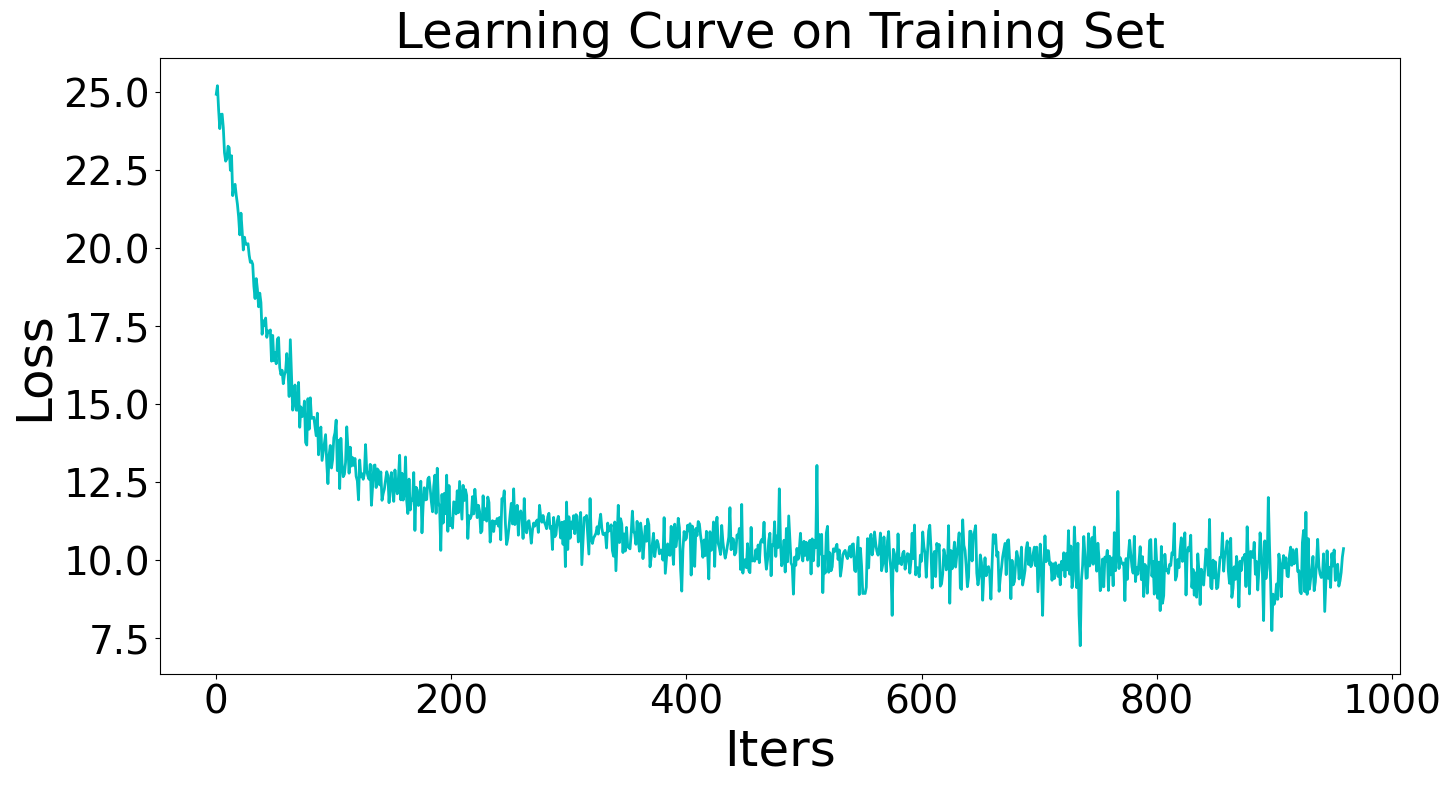

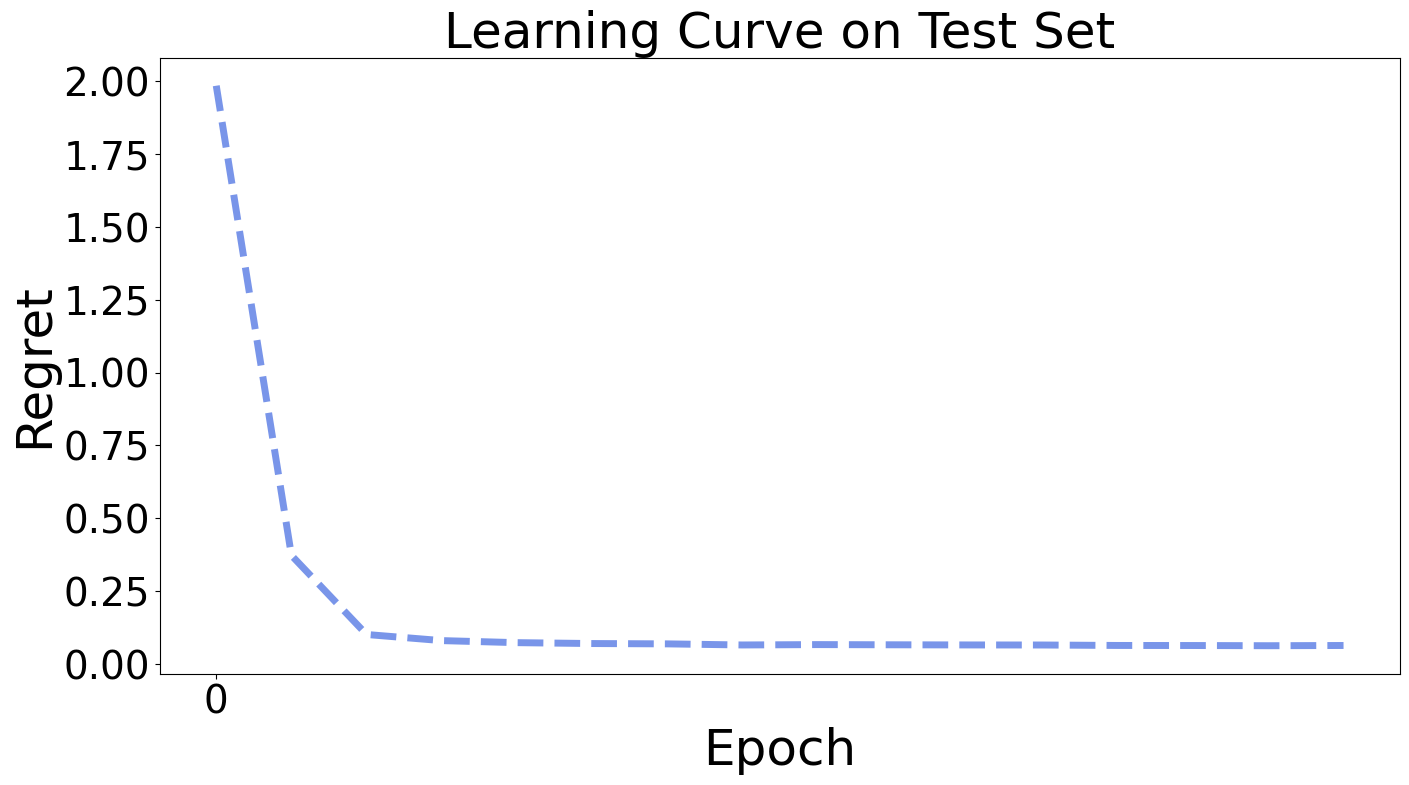

In [26]:
plot(loss_log, regret_log, num_epochs, log_step)